# Installation

In [ ]:
!pip3 install python-chess
!pip3 install cairosvg

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 45 kB 1.7 MB/s 
     |████████████████████████████████| 88 kB 4.0 MB/s 
  Created wheel for cairocffi: filename=cairocffi-1.3.0-py3-none-any.whl size=89668 sha256=bc8a33c597d101c0e75a97bb48ea28af6b2167ad33c57327e2939f589f035977
  Stored in directory: /root/.cache/pip/wheels/4e/ca/e1/5c8a9692a27f639a07c949044bec943f26c81cd53d3805319f
Successfully built cairocffi


# Import

In [ ]:
from abc import ABC, abstractmethod
from collections import defaultdict
import math
import random
import hashlib
import copy
import chess
import chess.svg
import cairosvg
from cairosvg import svg2png
import cv2
from google.colab.patches import cv2_imshow
import chess
import chess.svg
from IPython.display import clear_output
import time

# Monte Carlo Tree Search

In [ ]:
class MCTS:
    def __init__(self, c=1.414):
        self.w = defaultdict(int)  
        self.n = defaultdict(int) 
        self.children = dict()  
        self.c = c

    def choose_move(self, node):
        def score(n):
            if self.n[n] == 0:
                return float("-inf")  
            return self.w[n] / self.n[n]  

        if node.is_finished():
            raise RuntimeError(f"choose called on terminal node {node}")

        if node not in self.children:
            return node.find_random_child()

        return max(self.children[node], key=score)

    def uct_selection(self, node):
        assert all(n in self.children for n in self.children[node])

        def uct(n):
            return self.w[n] / self.n[n] + self.c * math.sqrt(math.log(self.n[node]) / self.n[n])

        return max(self.children[node], key=uct)

    def selection(self, node):
        path = []
        while True:
            path.append(node)
            if node not in self.children or not self.children[node]:
                return path
            unexplored = self.children[node] - self.children.keys()
            if unexplored:
                n = unexplored.pop()
                path.append(n)
                return path
            node = self.uct_selection(node)

    def expansion(self, node):
        if node in self.children:
            return
        else: 
          self.children[node] = node.find_children()

    def rollout(self, node):
        invert = True
        while True:
            if node.is_finished():
                reward = node.reward()
                return (1 - reward) if invert else reward
            node = node.find_random_child()
            invert = not invert

    def backpropagation(self, path, reward):
        for node in reversed(path):
            self.n[node] += 1
            self.w[node] += reward
            reward = 1 - reward

    def mcts_simulate(self, node):       
        path = self.selection(node)
        leaf = path[-1]
        self.expansion(leaf)
        reward = self.rollout(leaf)
        self.backpropagation(path, reward)

In [ ]:
class Node():
  def __init__(self, board):
    self.board = board

  def find_children(self):
    if self.is_finished():
      return set()

    return{
        self.push_move(m) for m in self.board.legal_moves
    }

  def find_random_child(self):
    if self.is_finished():
      return None

    moves = list(self.board.legal_moves)
    m = random.choice(moves)
    return self.push_move(m)

  def player_win(self, turn):
    if self.board.result() == '1-0' and turn:
      return True

    if self.board.result() == '0-1' and not turn:
      return True

    return False

  def reward(self):
    if self.board.result() == '1/2-1/2':
      return 0.5

    if self.player_win(not self.board.turn):
      return 0.0

  def push_move(self, move):
    child = self.board.copy()
    child.push(move)
    return Node(child)

  def is_finished(self):
    return self.board.is_game_over()

# Minimax

In [ ]:
def minimaxRoot(depth, board,isMaximizing):
    possibleMoves = board.legal_moves
    bestMove = -9999
    secondBest = -9999
    thirdBest = -9999
    bestMoveFinal = None
    for x in possibleMoves:
        move = chess.Move.from_uci(str(x))
        board.push(move)
        value = max(bestMove, minimax(depth - 1, board, not isMaximizing))
        board.pop()
        if( value > bestMove):
            # print("Best score: " ,str(bestMove))
            # print("Best move: ",str(bestMoveFinal))
            # print("Second best: ", str(secondBest))
            thirdBest = secondBest
            secondBest = bestMove
            bestMove = value
            bestMoveFinal = move
    return bestMoveFinal

In [ ]:
def minimax(depth, board, is_maximizing):
    if(depth == 0):
        return -evaluation(board)
    possibleMoves = board.legal_moves
    if(is_maximizing):
        bestMove = -9999
        for x in possibleMoves:
            move = chess.Move.from_uci(str(x))
            board.push(move)
            bestMove = max(bestMove,minimax(depth - 1, board, not is_maximizing))
            board.pop()
        return bestMove
    else:
        bestMove = 9999
        for x in possibleMoves:
            move = chess.Move.from_uci(str(x))
            board.push(move)
            bestMove = min(bestMove, minimax(depth - 1, board, not is_maximizing))
            board.pop()
        return bestMove

In [ ]:
def evaluation(board):
    i = 0
    evaluation = 0
    x = True
    try:
        x = bool(board.piece_at(i).color)
    except AttributeError as e:
        x = x
    while i < 63:
        i += 1
        evaluation = evaluation + (getPieceValue(str(board.piece_at(i))) if x else -getPieceValue(str(board.piece_at(i))))
    return evaluation

In [ ]:
def getPieceValue(piece):
    if(piece == None):
        return 0
    value = 0
    if piece == "P" or piece == "p":
        value = 10
    if piece == "N" or piece == "n":
        value = 30
    if piece == "B" or piece == "b":
        value = 30
    if piece == "R" or piece == "r":
        value = 50
    if piece == "Q" or piece == "q":
        value = 90
    if piece == 'K' or piece == 'k':
        value = 900
    #value = value if (board.piece_at(place)).color else -value
    return value

# Utils

In [ ]:
def write_and_show_board(current_board):
  board_img = chess.svg.board(current_board, flipped = False)
  svg2png(bytestring=board_img,write_to='/content/board.png')
  img = cv2.imread('/content/board.png', 1)
  cv2_imshow(img)

In [ ]:
def play_chess_human_MCTS():
  tree = MCTS()
  game = Node(chess.Board())
  write_and_show_board(game.board)
  count = 0
  print("Number of moves: ", count)
  while True:
    while True:
      move_str = input("Enter your move: ")
      move = chess.Move.from_uci(move_str)
      if move in list(game.board.legal_moves):
        game = game.push_move(move)
        break
      else:
        print("Invalid move")      
    clear_output()   
    write_and_show_board(game.board)
    count += 1
    print("Number of moves: ", count)    
    if game.is_finished():
      if game.board.is_stalemate():
        print("Draw")
      if game.board.is_checkmate():
        print("You win")
      break
   
    print("Please wait AI to make the decision...")
    for _ in range(50):
      tree.mcts_simulate(game)
    game = tree.choose_move(game)   
    clear_output()
    write_and_show_board(game.board)
    count += 1
    print("Number of moves: ", count)
    if game.is_finished():
      if game.board.is_stalemate():
        print("Draw")
      if game.board.is_checkmate():
        print("AI wins")
      break

In [ ]:
def play_chess_human_minimax():
    board = chess.Board()
    n = 0
    print(board)
    while n < 100:
        if n%2 == 0:
            move = input("Enter move: ")
            move = chess.Move.from_uci(str(move))
            board.push(move)
        else:
            print("Computers Turn:")
            move = minimaxRoot(4,board,True)
            move = chess.Move.from_uci(str(move))
            board.push(move)
        print(board)
        n += 1

In [ ]:
def play_chess_MCTS_minimax():
  tree = MCTS()
  game = Node(chess.Board())
  write_and_show_board(game.board)
  count = 0
  count_minimax = 0
  count_MCTS = 0
  time_minimax = float(0)
  time_MCTS = float(0)
  print("Number of moves: ", count)
  while True:
    print("Please wait MCTS to make the decision...")
    start = time.process_time()
    for _ in range(50):
      tree.mcts_simulate(game)
    game = tree.choose_move(game)
    end = time.process_time()
    time_MCTS += (end - start)
    clear_output()
    write_and_show_board(game.board)
    count += 1
    count_MCTS += 1
    print("Number of moves: ", count)
    if game.is_finished():
      if game.board.is_stalemate():
        print("Draw")
      if game.board.is_checkmate():
        print("MCTS wins")
      break  

    print("Please wait minimax to make the decision...")
    start = time.process_time()
    move = minimaxRoot(4,game.board,True)
    move = chess.Move.from_uci(str(move))
    game = game.push_move(move)
    end = time.process_time()
    time_minimax += (end - start)
    clear_output()   
    write_and_show_board(game.board)
    count += 1
    count_minimax += 1
    print("Number of moves: ", count)    
    if game.is_finished():
      if game.board.is_stalemate():
        print("Draw")
      if game.board.is_checkmate():
        print("Minimax win")
      break

  time_minimax /= float(count_minimax)
  time_MCTS /= float(count_MCTS)
  print("Minimax average time: ", time_minimax, "seconds")
  print("MCTS average time: ", time_MCTS, "seconds")

In [ ]:
def play_chess_minimax_MCTS():
  tree = MCTS()
  game = Node(chess.Board())
  write_and_show_board(game.board)
  count = 0
  count_minimax = 0
  count_MCTS = 0
  time_minimax = float(0)
  time_MCTS = float(0)
  print("Number of moves: ", count)
  while True:
    print("Please wait minimax to make the decision...")
    start = time.process_time()
    move = minimaxRoot(4,game.board,True)
    move = chess.Move.from_uci(str(move))
    game = game.push_move(move)
    end = time.process_time()
    time_minimax += (end - start)
    clear_output()   
    write_and_show_board(game.board)
    count += 1
    count_minimax += 1
    print("Number of moves: ", count)    
    if game.is_finished():
      if game.board.is_stalemate():
        print("Draw")
      if game.board.is_checkmate():
        print("Minimax win")
      break

    print("Please wait MCTS to make the decision...")
    start = time.process_time()
    for _ in range(50):
      tree.mcts_simulate(game)
    game = tree.choose_move(game)
    end = time.process_time()
    time_MCTS += (end - start)
    clear_output()
    write_and_show_board(game.board)
    count += 1
    count_MCTS += 1
    print("Number of moves: ", count)
    if game.is_finished():
      if game.board.is_stalemate():
        print("Draw")
      if game.board.is_checkmate():
        print("MCTS wins")
      break  

  time_minimax /= float(count_minimax)
  time_MCTS /= float(count_MCTS)
  print("Minimax average time: ", time_minimax, "seconds")
  print("MCTS average time: ", time_MCTS, "seconds")

# Test - Human and MCTS

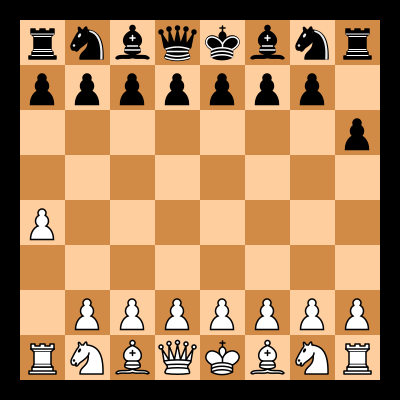

Number of moves:  2


KeyboardInterrupt: ignored

In [ ]:
play_chess_human_MCTS()

# Test - Human and Minimax

In [ ]:
play_chess_human_minimax()

r n b q k b n r
p p p p p p p p
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . . . . . .
P P P P P P P P
R N B Q K B N R
Enter move: a2a4
r n b q k b n r
p p p p p p p p
. . . . . . . .
. . . . . . . .
P . . . . . . .
. . . . . . . .
. P P P P P P P
R N B Q K B N R
Computers Turn:
r n b q k b . r
p p p p p p p p
. . . . . . . n
. . . . . . . .
P . . . . . . .
. . . . . . . .
. P P P P P P P
R N B Q K B N R


KeyboardInterrupt: ignored

# Test - MCTS and Minimax (MCTS First)

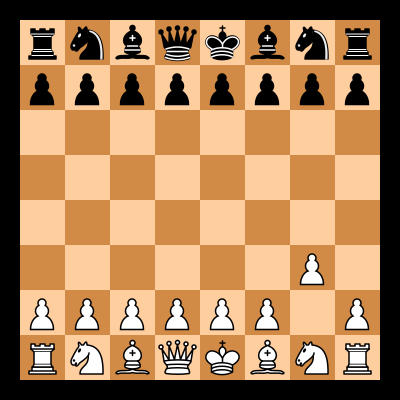

Number of moves:  1
Please wait minimax to make the decision...


KeyboardInterrupt: ignored

In [ ]:
play_chess_MCTS_minimax()

# Test - MCTS and Minimax (Minimax First)

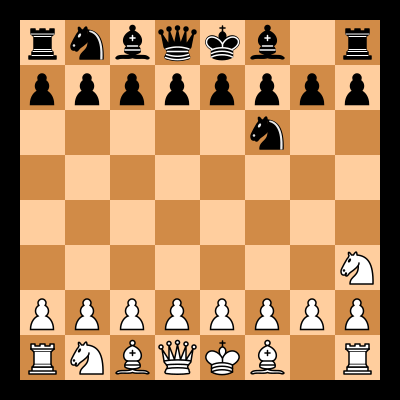

Number of moves:  2
Please wait minimax to make the decision...


KeyboardInterrupt: ignored

In [ ]:
play_chess_minimax_MCTS()